# Stochastic functions in pyro

In [27]:
import torch
import torch.distributions as tdist
import pyro
import pyro.distributions as pdist
import matplotlib.pyplot as plt

In [2]:
pyro.set_rng_seed(101)

## Sampling basics

In [3]:
normal = tdist.Normal(0, 1) # standard normal
x = normal.rsample()
print("sample", x.numpy())
print("log prob", normal.log_prob(x).numpy())

sample -1.3905061
log prob -1.8856921


In [4]:
# a simple weather model
def weather():
    cloudy = tdist.Bernoulli(0.3).sample()
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny':75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny':15.0}[cloudy]
    temp = tdist.Normal(mean_temp, scale_temp).rsample()
    return cloudy, temp.item()

In [5]:
weather()

('cloudy', 46.847618103027344)

Rewrite using pyro distributions and pyro.sample:

In [6]:
x = pyro.sample("my_sample", pdist.Normal(0, 1))
print(x)

tensor(0.9544)


In [7]:
def weather():
    cloudy = pyro.sample('cloudy', pdist.Bernoulli(0.3))
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny':75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny':15.0}[cloudy]
    temp = pyro.sample('temp', pdist.Normal(mean_temp, scale_temp))
    return cloudy, temp.item()

for _ in range(3):
    print(weather())

('sunny', 94.37557983398438)
('sunny', 72.5186767578125)
('cloudy', 54.18292999267578)


## Arbitrary logic

In [11]:
# composition of functions (weather from earlier)
def ice_cream_sales():
    cloudy, temp = weather()
    expected_sales = 200. if cloudy == 'sunny' and temp > 80.0 else 50.
    ice_cream = pyro.sample('ice_cream', pdist.Normal(expected_sales, 10))
    return ice_cream

for _ in range(3):
    print(ice_cream_sales())

tensor(43.7448)
tensor(201.5232)
tensor(39.8800)


In [25]:
# recursive functions
def geometric(p, t=None):
    if t is None:
        t = 0
    x = pyro.sample(f"x{t}", pdist.Bernoulli(p))
    if x.item() == 1:
        return 0
    else:
        return 1 + geometric(p, t+1)

for _ in range(3):
    print(geometric(0.25))

1
2
8


In [29]:
# higher-order functions
def normal_product(loc, scale):
    z1 = pyro.sample("z1", pdist.Normal(loc, scale))
    z2 = pyro.sample("z2", pdist.Normal(loc, scale))
    y = z1 * z2
    return y

def make_normal_normal(scale):
    mu_latent = pyro.sample("mu_latent", pdist.Normal(0, 1))
    return normal_product(mu_latent, scale)

for _ in range(3):
    print(make_normal_normal(1.))

tensor(1.5706)
tensor(-0.7633)
tensor(1.3741)


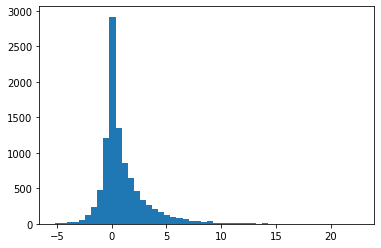

In [30]:
data = [make_normal_normal(1.) for _ in range(10000)]
plt.hist(data, bins=50)
plt.show()